## 모델 레이어 구현

In [114]:
!pip install torchsummary

In [115]:
import torch
import torch.nn as nn
import numpy as np
from torchsummary import summary

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [118]:
class Basicblock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1,downsample = None):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels*self.expansion)
        )
        self.downsample = downsample
        self.relu1 = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        x += identity
        x = self.relu1(x)

        return x

In [119]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels*self.expansion)
        )
        self.downsample = downsample
        self.relu1 = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        x += identity
        x = self.relu1(x)
        return x

In [120]:
class Resnet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
      super().__init__()
      self.in_channels = 64

      self.conv1 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7,stride=2, padding=3, bias=False),
          nn.BatchNorm2d(64),
          nn.ReLU()
      )
      self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.conv2 = self._make_layer(block, 64, num_blocks[0], stride=1)
      self.conv3 = self._make_layer(block, 128, num_blocks[1], stride=2)
      self.conv4 = self._make_layer(block, 256, num_blocks[2], stride=2)
      self.conv5 = self._make_layer(block, 512, num_blocks[3], stride=2)

      self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
      self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        for _ in range(1, num_blocks):
            layers.append(block(out_channels * block.expansion, out_channels))
        self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
      x = self.conv1(x)
      x = self.pool1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = self.fc(x)
      return x

In [121]:
class Model:
    def resnet18(self):
        return Resnet(Basicblock, [2, 2, 2, 2])

    def resnet34(self):
        return Resnet(Basicblock, [3, 4, 6, 3])

    def resnet50(self):
        return Resnet(Bottleneck, [3, 4, 6, 3])

    def resnet101(self):
        return Resnet(Bottleneck, [3, 4, 23, 3])

    def resnet152(self):
        return Resnet(Bottleneck, [3, 8, 36, 3])

In [122]:
model = Model().resnet50().to(device)
summary(model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## 데이터셋

In [123]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

In [124]:
path = '/content/drive/MyDrive/CIFAR10'
if not os.path.exists(path):
    os.mkdir(path)

transfor = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root=path, train=True, download=True, transform=transfor)
testset = datasets.CIFAR10(root=path, train=False, download=True, transform=transfor)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [125]:
images, labels = next(iter(trainloader))

In [126]:
import matplotlib.pyplot as plt
images[0]

tensor([[[0.5725, 0.5412, 0.6039,  ..., 0.5373, 0.5176, 0.4863],
         [0.4863, 0.4510, 0.4667,  ..., 0.3922, 0.3569, 0.4784],
         [0.4980, 0.4784, 0.4667,  ..., 0.3882, 0.3686, 0.4706],
         ...,
         [0.7961, 0.7490, 0.4510,  ..., 0.6118, 0.6078, 0.6667],
         [0.7686, 0.7725, 0.6863,  ..., 0.6510, 0.6353, 0.6314],
         [0.7451, 0.7765, 0.7686,  ..., 0.7255, 0.7020, 0.6745]],

        [[0.5451, 0.5098, 0.5451,  ..., 0.4941, 0.4745, 0.4353],
         [0.4667, 0.4353, 0.4353,  ..., 0.3882, 0.3529, 0.4549],
         [0.4588, 0.4275, 0.4196,  ..., 0.4039, 0.3804, 0.4549],
         ...,
         [0.7294, 0.7020, 0.4235,  ..., 0.5804, 0.5843, 0.6392],
         [0.6902, 0.7059, 0.6431,  ..., 0.6196, 0.6118, 0.6039],
         [0.6706, 0.6980, 0.7137,  ..., 0.6667, 0.6471, 0.6275]],

        [[0.4588, 0.4353, 0.4784,  ..., 0.4157, 0.4039, 0.3961],
         [0.4039, 0.3765, 0.3725,  ..., 0.3176, 0.3020, 0.4157],
         [0.4039, 0.3725, 0.3608,  ..., 0.3451, 0.3333, 0.

In [127]:
images.size()

torch.Size([256, 3, 32, 32])

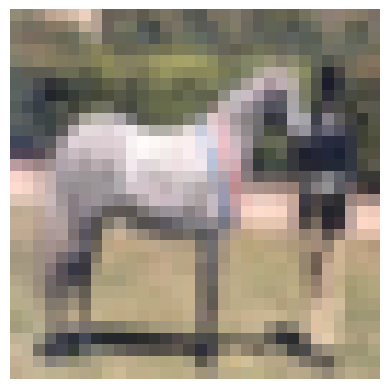

In [128]:
# 첫 번째 이미지 선택
first_image = images[0]  # (3, 32, 32)

# 채널 순서를 (높이, 너비, 채널)로 변경
first_image = first_image.permute(1, 2, 0)  # (32, 32, 3)

# 이미지 시각화
plt.imshow(first_image)
plt.axis('off')  # 축 숨기기
plt.show()

In [129]:
len(trainset)

50000

In [130]:
# 이미지 평균 및 표준편차 계산
mean = torch.zeros(3)
std = torch.zeros(3)
for images, _ in trainloader:
    images = images.view(images.size(0), images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(trainset)
std /= len(trainset)

mean = mean.numpy().tolist()
std = std.numpy().tolist()

mean,std

([0.491399884223938, 0.48215845227241516, 0.4465309679508209],
 [0.2023009955883026, 0.19941280782222748, 0.20096160471439362])

In [131]:
import json
# 저장할 파일 경로
file_path = '/content/drive/MyDrive/resnet/mean_std.json'

# 딕셔너리 형태로 데이터 준비
data = {
    'mean': mean,
    'std': std
}

# JSON 파일로 저장
with open(file_path, 'w') as f:
    json.dump(data, f, indent=4)

In [132]:
# JSON 파일 경로
file_path = '/content/drive/MyDrive/resnet/mean_std.json'

# JSON 파일에서 데이터 불러오기
with open(file_path, 'r') as f:
    data = json.load(f)

mean = data['mean']
std = data['std']
mean,std

([0.491399884223938, 0.48215845227241516, 0.4465309679508209],
 [0.2023009955883026, 0.19941280782222748, 0.20096160471439362])

In [133]:
# 데이터셋 전처리
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 변경
    transforms.ToTensor(),
    transforms.Normalize(mean, std),  # 계산된 평균과 표준편차를 이용한 정규화
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 변경
    transforms.ToTensor(),
    transforms.Normalize(mean, std),  # 계산된 평균과 표준편차를 이용한 정규화
])


# CIFAR-10
trainset = datasets.CIFAR10(root=path, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root=path, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [134]:
# 데이터로더 정보를 출력하는 함수
def print_dataloader_info(dataloader, loader_name):
    print(f"{loader_name} 정보:")
    for batch_idx, (images, labels) in enumerate(dataloader):
        print(f"배치 인덱스: {batch_idx}")
        print(f"이미지 크기: {images.size()}")
        if isinstance(labels, torch.Tensor):
            print(f"라벨 크기: {labels.size()}")
            print(f'라벨의 데이터타입 : {labels[0].dtype}')
        else:
            print(f"라벨 크기: {len(labels)}")
            print(f'라벨의 데이터타입 : {type(labels[0])}')
        if batch_idx == 0:  # 첫 번째 배치 정보만 출력
            break

# train_loader 정보 출력
print_dataloader_info(trainloader, "Train Loader")
print("\n")
# test_loader 정보 출력
print_dataloader_info(testloader, "Test Loader")

Train Loader 정보:
배치 인덱스: 0
이미지 크기: torch.Size([4, 3, 224, 224])
라벨 크기: torch.Size([4])
라벨의 데이터타입 : torch.int64


Test Loader 정보:
배치 인덱스: 0
이미지 크기: torch.Size([4, 3, 224, 224])
라벨 크기: torch.Size([4])
라벨의 데이터타입 : torch.int64


## 모델 훈련


In [71]:
# hyper parameters
initial_learning_rate = 0.1
num_epochs = 10
epoch_step = 2

# Loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=initial_learning_rate, momentum=0.9, weight_decay=0.0001)

# scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

In [72]:
def model_train(model, data_loader, criterion, optimizer, epoch):
    model.train()
    global epoch_step
    running_size, running_loss, correct = 0.0, 0.0, 0.0

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        pbar = tqdm(data_loader)
    else:
        pbar = data_loader

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_size += images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar.set_description('[Training] loss: ' +
                                f'{running_loss / running_size:.4f}, accuracy: ' +
                                f'{correct / running_size:.4f}')
        del images, labels, outputs, loss
        torch.cuda.empty_cache()

    avg_accuracy = correct / running_size
    avg_loss = running_loss / running_size

    return avg_loss, avg_accuracy

def model_eval(model, data_loader, criterion, epoch):
    model.eval()
    with torch.no_grad():
        running_loss, correct = 0.0, 0.0

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar = tqdm(data_loader)
        else:
            pbar = data_loader

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1)

            correct += torch.sum(pred == labels).item()
            running_loss += criterion(outputs, labels).item() * images.size(0)

        accuracy = correct / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)
        return loss, accuracy

In [73]:
# 모델 학습 및 평가 코드
loss, accuracy = [], []
num_epochs = 10
epoch_step = 2

for epoch in range(num_epochs):
    train_loss, train_accuracy = model_train(model, trainloader, criterion, optimizer, epoch)
    test_loss, test_accuracy = model_eval(model, testloader, criterion, epoch)

    loss.append([train_loss, test_loss])
    accuracy.append([train_accuracy, test_accuracy])

    scheduler.step(test_loss)  # 스케줄러 업데이트

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f"epoch {epoch+1:03d}, Training loss: " +
              f"{train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

# 모델 상태 저장
model_save_path = '/content/drive/MyDrive/resnet/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

[Training] loss: 2.3168, accuracy: 0.1425:  48%|████▊     | 6002/12500 [4:07:00<4:27:25,  2.47s/it]


KeyboardInterrupt: 

## 그래프 확인

In [ ]:
import matplotlib.pyplot as plt

# 손실 그래프
train_losses, val_losses = zip(*loss)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train-Val Loss')

# 정확도 그래프
train_accuracies, val_accuracies = zip(*accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train-Val Accuracy')

plt.tight_layout()
plt.show()

## 모델 실행


In [ ]:
model_save_path = '/content/drive/MyDrive/resnet/model.pth'
model = Model().resnet50().to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

In [163]:
images, labels = next(iter(testloader))
images[0]

tensor([[[ 0.6337,  0.6337,  0.6337,  ..., -0.1804, -0.1804, -0.1804],
         [ 0.6337,  0.6337,  0.6337,  ..., -0.1804, -0.1804, -0.1804],
         [ 0.6337,  0.6337,  0.6337,  ..., -0.1804, -0.1804, -0.1804],
         ...,
         [-1.3823, -1.3823, -1.3823,  ..., -2.0220, -2.0220, -2.0220],
         [-1.3823, -1.3823, -1.3823,  ..., -2.0220, -2.0220, -2.0220],
         [-1.3823, -1.3823, -1.3823,  ..., -2.0220, -2.0220, -2.0220]],

        [[-0.2153, -0.2153, -0.2153,  ..., -0.7463, -0.7463, -0.7463],
         [-0.2153, -0.2153, -0.2153,  ..., -0.7463, -0.7463, -0.7463],
         [-0.2153, -0.2153, -0.2153,  ..., -0.7463, -0.7463, -0.7463],
         ...,
         [-0.3137, -0.3137, -0.3137,  ..., -1.1003, -1.1003, -1.1003],
         [-0.3137, -0.3137, -0.3137,  ..., -1.1003, -1.1003, -1.1003],
         [-0.3137, -0.3137, -0.3137,  ..., -1.1003, -1.1003, -1.1003]],

        [[-1.2658, -1.2658, -1.2658,  ..., -1.5780, -1.5780, -1.5780],
         [-1.2658, -1.2658, -1.2658,  ..., -1

In [152]:
images[0].size()

torch.Size([3, 224, 224])

In [164]:
# 레이블 텐서를 넘파이 배열로 변환
label_indices = labels.numpy()

# 각 레이블 인덱스를 클래스 이름으로 변환
label_names = [class_labels[idx] for idx in label_indices]

print(label_names)

['cat', 'ship', 'ship', 'airplane']


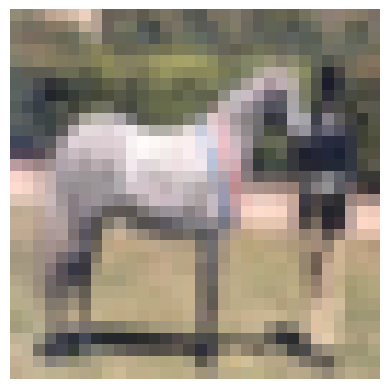

In [165]:
# 이미지 시각화
plt.imshow(first_image)
plt.axis('off')  # 축 숨기기
plt.show()

In [166]:
class_labels = trainset.classes
class_labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [167]:
test_image = images[0].unsqueeze(0)
test_image.size()

torch.Size([1, 3, 224, 224])

In [ ]:
# 이미지를 모델에 통과시켜 예측 수행
with torch.no_grad():  # 평가 시에는 gradient를 계산할 필요가 없음
    outputs = model(test_image)
value, label_idx = torch.max(outputs, 1)
value, label_idx

In [ ]:
# 예측된 클래스의 인덱스
predicted_index = label_idx.item()  # 텐서에서 값을 꺼내 정수로 변환

# 인덱스를 클래스 이름으로 매핑
predicted_label = class_labels[predicted_index]
predicted_label